In [ ]:
import sys
import numpy as np
from chmm_actions import CHMM,forwardE, backwardE, updateCE
import matplotlib.pyplot as plt
import igraph
from matplotlib import cm, colors
import os
import seaborn as sb
import scipy
import random
import string
import copy
sys.path.append("/.../naturecomm_cscg/")


In [2]:
def get_mess_fwd(chmm, x, pseudocount=0.0, pseudocount_E=0.0):
    n_clones = chmm.n_clones
    E = np.zeros((n_clones.sum(), len(n_clones)))
    last = 0
    for c in range(len(n_clones)):
        E[last : last + n_clones[c], c] = 1
        last += n_clones[c]
    E += pseudocount_E
    norm = E.sum(1, keepdims=True)
    norm[norm == 0] = 1
    E /= norm
    T = chmm.C + pseudocount
    norm = T.sum(2, keepdims=True)
    norm[norm == 0] = 1
    T /= norm
    T = T.mean(0, keepdims=True)
    log2_lik, mess_fwd = forwardE(
        T.transpose(0, 2, 1), E, chmm.Pi_x, chmm.n_clones, x, x * 0, store_messages=True
    )
    return mess_fwd


In [3]:
def transition_graph_plotter(chmm, x,a,axs, axs_counter):
    chmm.pseudocount = 0.0
    chmm.learn_viterbi_T(x, a, n_iter=100)
    states = chmm.decode(x, a)[1]
    v = np.unique(states)

    num_obs = 8

    color_dict = {}
    color_order = ['#808080', '#FBB4B9','#A8D8A7','#41AE76','#C51B8A','#045A8D','#000000','lightgray']
    i = 0
    for letter in string.ascii_uppercase[0:num_obs]:
        color_dict[letter_num_dict[letter]] = color_order[i]
        i+=1

    ##fig, axs = plt.subplots(1,figsize = (8,8))
    states = chmm.decode(x, a)[1]
    v = np.unique(states)

    edge_nodes = np.floor(v/100)
    edge_color = []
    for i in range(0, len(v)):
        edge_color.append(color_dict.get(edge_nodes[i]))

    T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)

    g = igraph.Graph.Adjacency((A > 0).tolist())
    
    if axs_counter>=2:
        edge_color[np.where(v==453)[0][0]] = '#006D2C'
    if axs_counter==3:
        edge_color[np.where(v==316)[0][0]] = '#F768A1'
    if axs_counter==1:
        edge_color[np.where(v==413)[0][0]] = '#006D2C'
        
    
    igraph.plot(g,vertex_color= edge_color, vertex_size=20, target= axs) ##vertex_label= v
    ##plt.show()

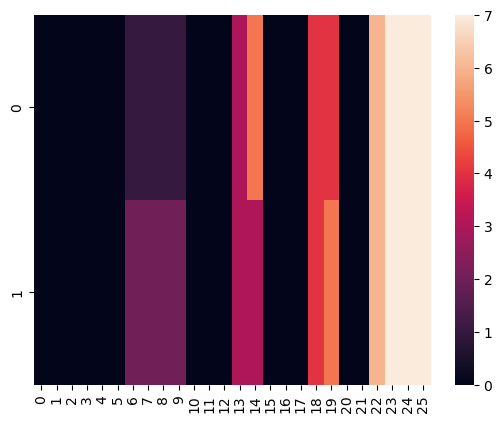

Average number of clones: 100.0


  2%|▌                        | 2/100 [00:00<00:00, 196.97it/s, train_bps=0.237]


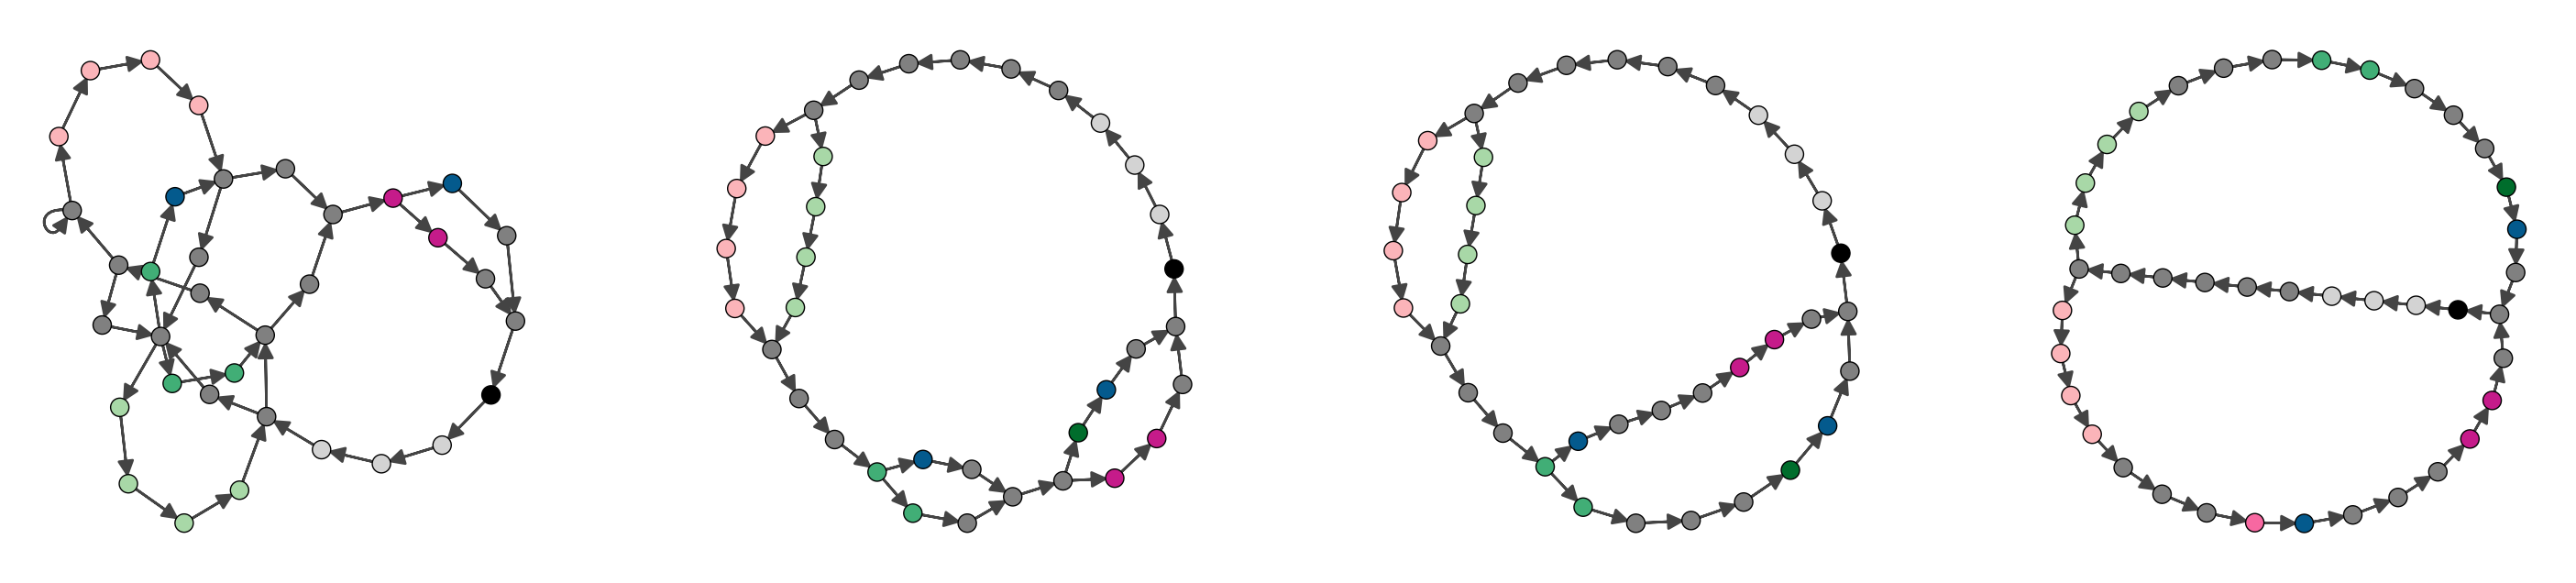

In [4]:
np.random.seed(0)

trial1x_let = np.repeat(np.array(['A','A','A','A','A','A','B', 'B', 'B', 'B', 'A','A','A', 'D','F','A','A','A','E','E', 'A', 'A', 'G','H','H','H']),1)
trial2x_let = np.repeat(np.array(['A','A','A','A','A','A','C', 'C', 'C', 'C', 'A','A','A', 'D','D','A','A','A','E','F', 'A', 'A','G','H','H','H']),1)

 

num_trials = 5
trials = np.random.choice(2,num_trials-2)
trials = np.concatenate((trials, np.array([0,1])))

ln = np.linspace(0,7,8)##np.random.choice(8, size=8, replace=False)
letter_num_dict = {'A': ln[0], 'B': ln[1], 'C': ln[2], 'D': ln[3], 'E': ln[4], 'F': ln[5], 'G': ln[6], 'H':ln[7]}

trial1x = np.zeros(len(trial1x_let))
trial2x = np.zeros(len(trial2x_let))
for i in range(len(trial1x_let)):
    trial1x[i]= int(letter_num_dict.get(trial1x_let[i]))
    trial2x[i] = int(letter_num_dict.get(trial2x_let[i]))
sb.heatmap([trial1x, trial2x])
plt.show()

trials = np.random.choice(2,num_trials-2)
trials = np.concatenate((trials, np.array([0,1])))

tr_len = len(trial1x)
x = np.zeros(num_trials*tr_len, dtype = np.int64)


for trial in range(len(trials)):
    if trials[trial] == 0:
        x[trial*tr_len: (trial+1)*tr_len] = trial1x
    else:
        x[trial*tr_len: (trial+1)*tr_len] = trial2x
a = np.zeros(len(x), dtype=np.int64)
OBS = len(np.unique(x))


n_clones = (np.ones(OBS + 5, dtype=np.int64) * 100)
chmm = CHMM(n_clones=n_clones, pseudocount=1e-10, x=x, a=a, seed = 0)  # Initialize the model
axs_counter = 0

fig, axs = plt.subplots(1,4,figsize = (36,8))
for tot_iter in range(0,26):
    n_iter =10

    progression = chmm.learn_em_T(x, a, n_iter=n_iter, term_early=False)  # Training
    mess_fwd = get_mess_fwd(chmm, x, pseudocount_E=0.1)
    corrplot = np.zeros((len(trials), len(trials)))
    for trial1 in range(0, len(trials)):
        for trial2 in range(trial1, len(trials)):
            comp1 = mess_fwd[trial1*tr_len: (trial1+1)*tr_len,:]
            comp2 = mess_fwd[trial2*tr_len: (trial2+1)*tr_len,:]
            corrplot[trial1, trial2] = scipy.stats.pearsonr(comp1.flatten(), comp2.flatten())[0]
    ##sb.heatmap(corrplot)
    ##plt.show()

    trial1 = mess_fwd[-tr_len:,:]
    trial0 =  mess_fwd[-2*tr_len:-tr_len,:]
    corr_plot1 = np.zeros((tr_len, tr_len))
    corr_plot0 = np.zeros((tr_len, tr_len))
    corr_plot01 = np.zeros((tr_len, tr_len))
    for posi in range(0, tr_len):
        for posj in range(0, tr_len):
            corr_plot1[posi, posj] = scipy.stats.pearsonr(trial1[posi], trial1[posj])[0]
            corr_plot0[posi, posj] = scipy.stats.pearsonr(trial0[posi], trial0[posj])[0]
            corr_plot01[posi, posj] = scipy.stats.pearsonr(trial0[posi], trial1[posj])[0]
    if tot_iter == 0:
        all_corr = corr_plot01.copy()
    else:
        all_corr = np.dstack((all_corr,corr_plot01))
    
    if tot_iter in [0,5,10,25]:
        chmm_curr = copy.deepcopy(chmm)
        x_curr =  np.concatenate((trial1x, trial2x))
        x_curr = np.array(x_curr, dtype = np.int64)
        a_curr = np.zeros(len(x_curr), dtype=np.int64)
        transition_graph_plotter(chmm_curr,x_curr,a_curr,axs[axs_counter], axs_counter)
        axs_counter =  axs_counter + 1